Scaler saved to 'scaler.pkl'.
Epoch 1/100
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 111s 17ms/step - loss: 0.2761 - mae: 0.2638 - val_loss: 0.1127 - val_mae: 0.1526
Epoch 2/100
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 73s 13ms/step - loss: 0.1217 - mae: 0.1768 - val_loss: 0.0914 - val_mae: 0.1369
Epoch 3/100
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step - loss: 0.1067 - mae: 0.1630 - val_loss: 0.0868 - val_mae: 0.1358
Epoch 4/100
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 67s 12ms/step - loss: 0.0986 - mae: 0.1566 - val_loss: 0.0847 - val_mae: 0.1400
Epoch 5/100
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 71s 12ms/step - loss: 0.0951 - mae: 0.1531 - val_loss: 0.0833 - val_mae: 0.1325
Epoch 6/100
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 74s 13ms/step - loss: 0.0881 - mae: 0.1467 - val_loss: 0.0793 - val_mae: 0.1338
Epoch 7/100
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 76s 13ms/step - loss: 0.0878 - mae: 0.1447 - val_loss: 0.0715 - val_mae: 0.1244
Epoch 8/100
5701/5701 ━━━━━━━━━━━━━━━━━━━━ 94s 16ms/step - loss: 0.0863 - mae: 0.1438 - val_loss: 0.0710 - v

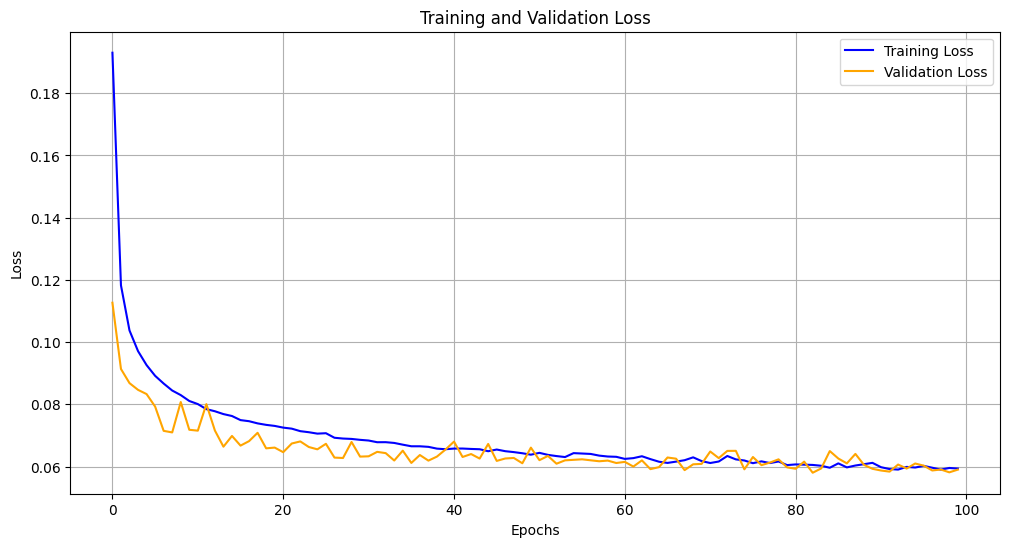

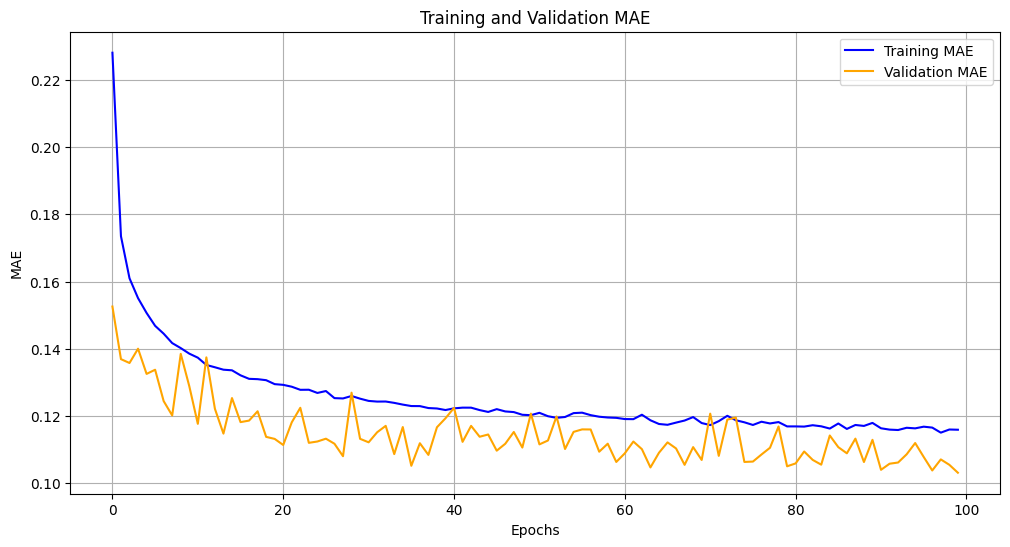

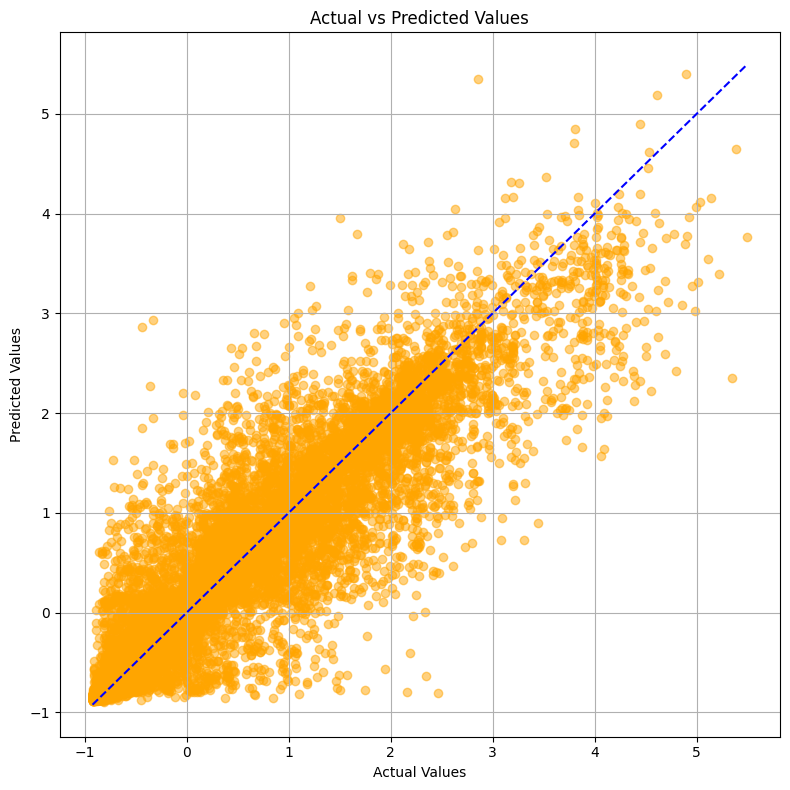

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Load your dataset
df = pd.read_csv(r'C:\Users\sireg\OneDrive\Desktop\Artificial Intelligence\normalized_data.csv', sep=',', low_memory=False)

# Convert 'Datetime' column to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')

# Feature Engineering: Extract additional features
df['Hour'] = df['Datetime'].dt.hour
df['Day_of_Week'] = df['Datetime'].dt.dayofweek
df['Day'] = df['Datetime'].dt.day
df['Minute'] = df['Datetime'].dt.minute

# Select relevant features
features = [
    "Global_active_power", "Global_intensity", "Sub_metering_1",
    "Sub_metering_2", "Sub_metering_3", "Hour", "Day_of_Week", "Day", "Minute"
]
target = "Global_active_power"

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features].values)

# Save the scaler for future inference
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved to 'scaler.pkl'.")

# Prepare dataset
seq_length = 30  # Sequence length

X, y = [], []
for i in range(len(scaled_data) - seq_length):
    X.append(scaled_data[i:i + seq_length])
    y.append(scaled_data[i + seq_length, 0])  # Target: Global_active_power

X = np.array(X)
y = np.array(y)

# Noise Injection Function
def add_gaussian_noise(data, noise_std=0.05):
    noise = np.random.normal(loc=0.0, scale=noise_std, size=data.shape)
    return data + noise

# Inject noise into the dataset
X_noisy = add_gaussian_noise(X, noise_std=0.05)

# Train, validation, and test split
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X_noisy[:train_size], X_noisy[train_size:train_size+val_size], X_noisy[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# CNN Block
def cnn_block(inputs, filters, kernel_size, strides, activation="relu"):
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, activation=activation)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    return x

# Global Attention Mechanism
def global_attention(inputs):
    attention_weights = layers.Dense(inputs.shape[-1], activation='softmax')(inputs)
    x = layers.Multiply()([inputs, attention_weights])
    return layers.GlobalAveragePooling1D()(x)

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x_ff = layers.Dense(ff_dim, activation="relu")(x)
    x_ff = layers.Dense(inputs.shape[-1])(x_ff)
    x = layers.Add()([x, x_ff])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x

# Build the model
inputs = layers.Input(shape=(seq_length, X_train.shape[2]))

# CNN Block
cnn_output = cnn_block(inputs, filters=64, kernel_size=3, strides=1)

# Transformer Encoder
transformer_output = transformer_encoder(cnn_output, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

# Global Attention
attention_output = global_attention(transformer_output)

# Dense layers for regression
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(attention_output)
outputs = layers.Dense(1, kernel_regularizer=regularizers.l2(0.01))(x)

# Model definition
model = models.Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

# Save the trained model
model.save("transformer_with_global_attention.keras")
print("Model saved to 'transformer_with_global_attention.keras'.")

# Evaluate the model on test data
y_pred_test = model.predict(X_test).flatten()
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE', color='blue')
plt.plot(history.history['val_mae'], label='Validation MAE', color='orange')
plt.title("Training and Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

# Scatter Plot: Actual vs Predicted Values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='orange')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--')  # Line of perfect prediction
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()
